In [16]:
# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Import dependencies
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Models
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from neuralprophet import NeuralProphet


In [18]:
# Read the Retail Turnover data

# Query the SQL database table populated with the data from:
# Table 1. Retail turnover, by industry group
# https://www.abs.gov.au/statistics/industry/retail-and-wholesale-trade/retail-trade-australia/latest-release#data-downloads
con = sqlite3.connect("db/ABS_RetailTurnover.db")
turnover_df = pd.read_sql_query("SELECT * from RetailTurnoverByIndustryGroup", con)
con.close()

turnover_df.head()

,RecordDate,Original__Turnover_FoodRetailing,Original__Turnover_HouseholdGoodsRetailing,Original__Turnover_ClothingFootwearAndPersonalAccessoryRetailing,Original__Turnover_DepartmentStores,Original__Turnover_OtherRetailing,Original__Turnover_CafesRestaurantsAndTakeawayFoodServices,Original__Turnover_TotalIndustry,SeasonallyAdjusted__Turnover_FoodRetailing,SeasonallyAdjusted__Turnover_HouseholdGoodsRetailing,...,SeasonallyAdjusted__Turnover_OtherRetailing,SeasonallyAdjusted__Turnover_CafesRestaurantsAndTakeawayFoodServices,SeasonallyAdjusted__Turnover_TotalIndustry,Trend__Turnover_FoodRetailing,Trend__Turnover_HouseholdGoodsRetailing,Trend__Turnover_ClothingFootwearAndPersonalAccessoryRetailing,Trend__Turnover_DepartmentStores,Trend__Turnover_OtherRetailing,Trend__Turnover_CafesRestaurantsAndTakeawayFoodServices,Trend__Turnover_TotalIndustry
0,1982-04-01,1162.6,592.3,359.9,460.1,479.1,342.4,3396.4,1167.1,653.4,...,507.9,349.8,3518.7,1173.2,652.9,362.7,482.4,505.1,347.6,3523.4
1,1982-05-01,1150.9,629.6,386.6,502.6,486.1,342.1,3497.9,1178.6,648.7,...,502.3,346.3,3527.6,1181.7,654.1,362.0,484.2,504.9,346.3,3533.6
2,1982-06-01,1160.0,607.4,350.5,443.8,467.5,328.7,3357.8,1203.7,655.7,...,506.9,350.8,3561.5,1192.7,655.6,361.9,486.4,504.7,345.9,3547.0
3,1982-07-01,1206.4,632.4,359.3,459.1,491.1,338.5,3486.8,1209.8,660.4,...,503.7,341.5,3553.9,1203.2,656.6,361.6,488.6,505.4,345.4,3560.6
4,1982-08-01,1152.5,622.6,325.2,438.4,485.7,331.5,3355.9,1198.7,659.8,...,506.0,342.7,3581.8,1213.5,656.5,361.9,489.8,505.6,346.4,3573.6


In [19]:
# Review the dataframe size to check the data was retrieved correctly 
turnover_df.shape

(509, 22)

In [20]:
# Define shorter names for the Retail Turnover categories
turnover_categories = ['Food', 'Household_Goods', 'Clothing_and_Footware', 'Department_Stores', 'Other_Retailing', 'Cafes_Restaurants_TakeAway']

In [21]:
# Focus on the Seasonally Adjusted Retail Turnover data
sa_turnover_df = turnover_df.iloc[9:, np.r_[0, 8:14]]
sa_turnover_df.columns = ['Year-Month'] + turnover_categories


In [22]:
# Convert datetime values from string to datetime type
sa_turnover_df['Year-Month'] = pd.to_datetime(sa_turnover_df['Year-Month'])

# Reset the dataframe index to be the datetime column
sa_turnover_df.reset_index(inplace=True, drop=True)
sa_turnover_df = sa_turnover_df.set_index(['Year-Month'])


In [23]:
# Convert data columns from object/string type to numeric
columns = sa_turnover_df.columns.to_list()
sa_turnover_df = sa_turnover_df[columns].apply(pd.to_numeric, errors='coerce')


In [24]:
# Check the restructure dataframe has date as the index, with turnover values in the columns
sa_turnover_df

,Food,Household_Goods,Clothing_and_Footware,Department_Stores,Other_Retailing,Cafes_Restaurants_TakeAway
Year-Month,,,,,,
1983-01-01,1240.5,702.9,386.1,471.2,525.6,369.3
1983-02-01,1312.2,712.4,379.2,502.7,536.5,378.0
1983-03-01,1293.4,728.4,395.2,502.8,536.9,366.1
1983-04-01,1301.2,722.2,424.0,537.4,536.0,364.4
1983-05-01,1294.5,710.1,390.5,492.5,538.6,366.9
...,...,...,...,...,...,...
2024-04-01,14285.9,5689.7,2940.4,1885.1,5611.4,5398.8
2024-05-01,14383.1,5755.8,2980.5,1873.3,5621.1,5388.4
2024-06-01,14420.0,5818.8,3001.7,1889.6,5671.4,5385.6


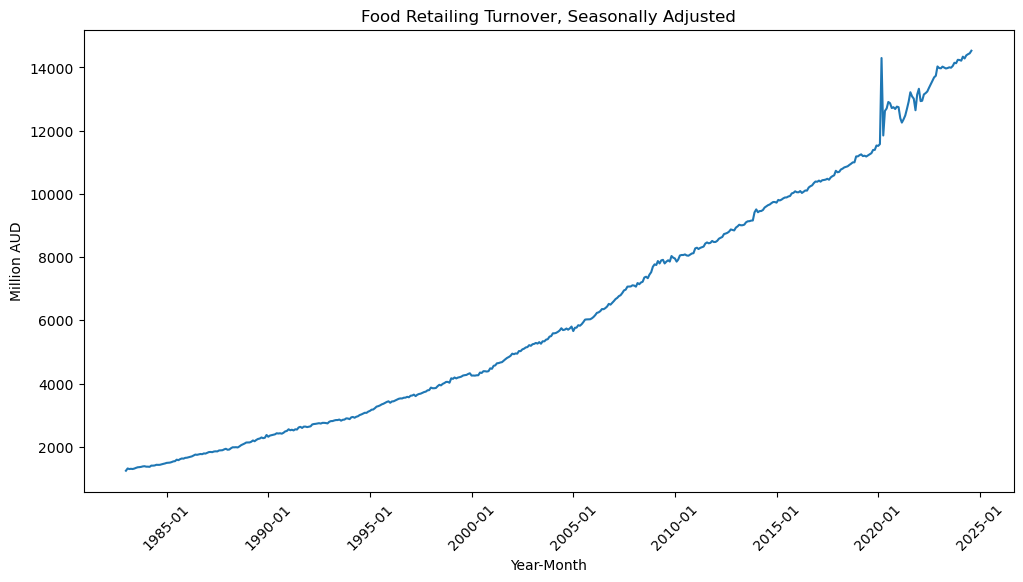

In [25]:
# Exploratory Data Analysis

#Format visualization
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

plt.title('Food Retailing Turnover, Seasonally Adjusted')
plt.ylabel('Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)

plt.plot(sa_turnover_df.index, sa_turnover_df['Food'])
plt.show()


### Normalize / Scale the dataset

In [26]:
# Normalize / Scale the dataset
# REVISIT

### Split Dataset into Training and Testing components

In [27]:
# str_forecast_from_date = "2020-11-01"
str_forecast_from_date = "2022-09-01"
forecast_from_date = pd.to_datetime(str_forecast_from_date, format='%Y-%m-%d')

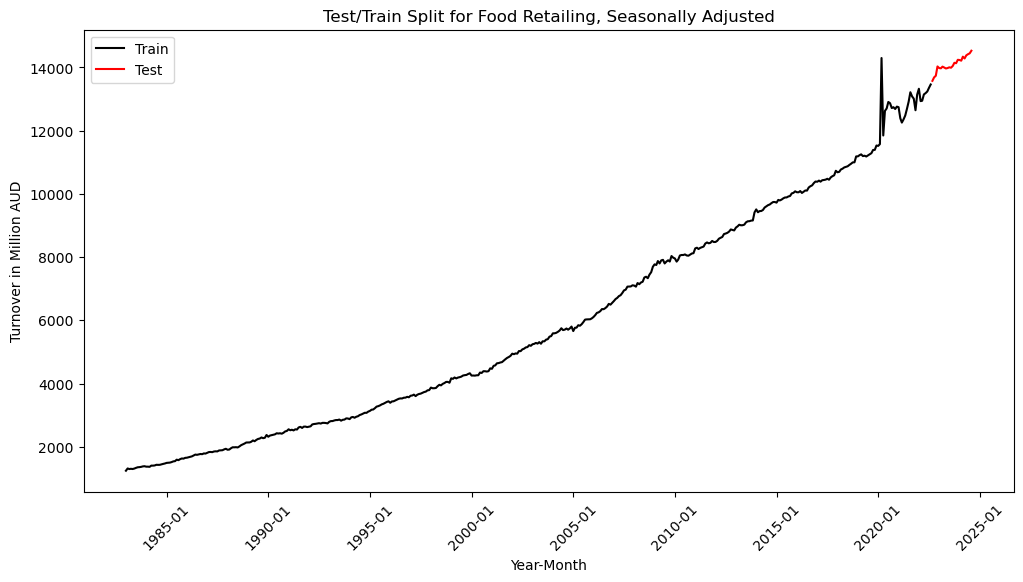

In [28]:
# Splitting the data into training and testing sets
train = sa_turnover_df[sa_turnover_df.index < forecast_from_date]
test = sa_turnover_df[sa_turnover_df.index >= forecast_from_date]

# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

plt.plot(train.index, train['Food'], color="black", label='Train')
plt.plot(test.index, test['Food'], color="red", label='Test')

plt.title('Test/Train Split for Food Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()  # Show legend to differentiate train/test
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Time series prediction - Statistical Models

## (1) ARMA

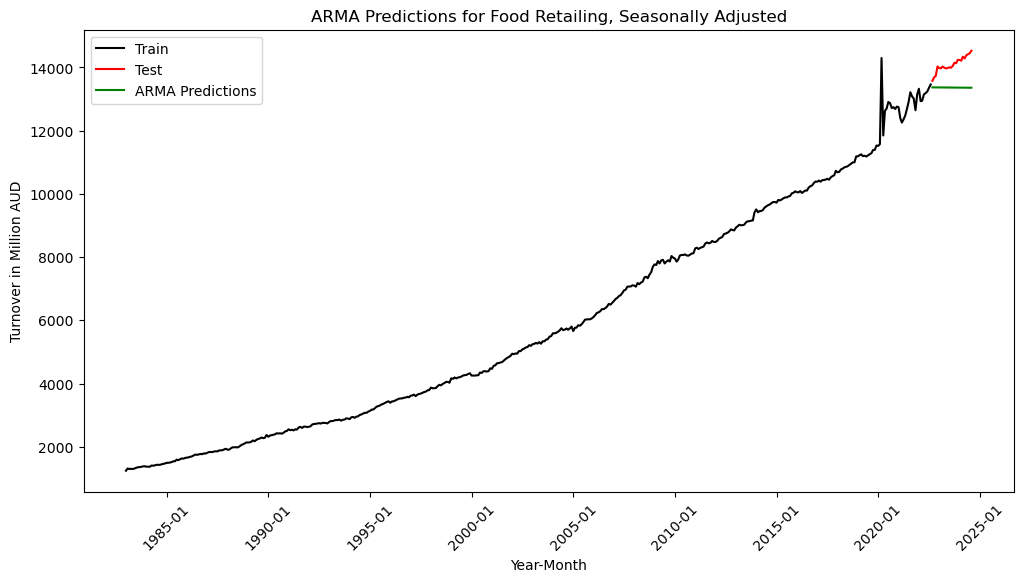

In [29]:
# Define the output
y = train['Food']
y_label_arma = "ARMA Predictions"

# Define ARMA Model
ARMAmodel = SARIMAX(y, order=(1, 0, 1))
ARMAmodel_fit = ARMAmodel.fit(disp=False)

# Generate Turnover predictions
y_pred_arma = ARMAmodel_fit.get_forecast(len(test))
y_pred_arma_df = y_pred_arma.conf_int(alpha=0.05)
y_pred_arma_df[y_label_arma] = ARMAmodel_fit.predict(start=y_pred_arma_df.index[0], end=y_pred_arma_df.index[-1])

# Align the index with test data
y_pred_arma_df.index = test.index

# Plot the Results
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train['Food'], label='Train', color='black')
plt.plot(test.index, test['Food'], label='Test', color='red')

# Plot the ARMA predictions
plt.plot(y_pred_arma_df[y_label_arma].index, y_pred_arma_df[y_label_arma], color='green', label=y_label_arma)

# Labels and Title
plt.title('ARMA Predictions for Food Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()
plt.show()

## (2) ARIMA

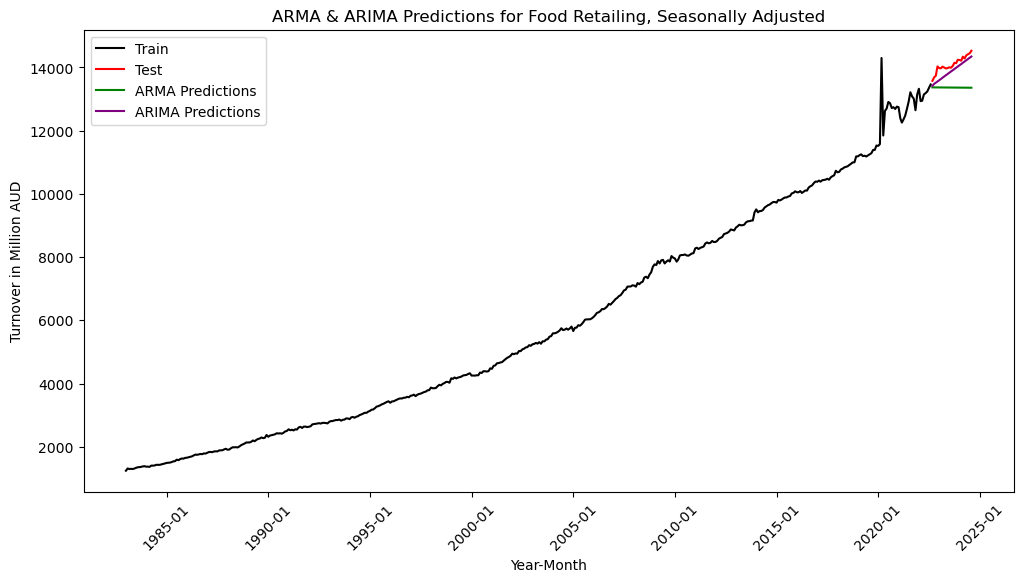

In [30]:
# Define the output
y = train['Food']
y_label_arima = "ARIMA Predictions"

# Define ARIMA Model
ARIMAmodel = ARIMA(y, order = (2, 2, 2)) # Adjust as necessary
ARIMAmodel_fit = ARIMAmodel.fit()

# Generate ARMA predictions
y_pred_arima = ARIMAmodel_fit.get_forecast(len(test.index))
y_pred_arima_df = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_arima_df[y_label_arima] = ARIMAmodel_fit.predict(start = y_pred_arima_df.index[0], end = y_pred_arima_df.index[-1])
y_pred_arima_df.index = test.index

# Plot the Results
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train['Food'], label='Train', color='black')
plt.plot(test.index, test['Food'], label='Test', color='red')

# Plot the ARMA predictions
plt.plot(y_pred_arma_df[y_label_arma].index, y_pred_arma_df[y_label_arma], color='green', label=y_label_arma)

# Plot ARIMA Predictions
plt.plot(y_pred_arima_df.index, y_pred_arima_df[y_label_arima], color='purple', label=y_label_arima)

# Labels and Title
plt.title('ARMA & ARIMA Predictions for Food Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



In [31]:
# REVISIT 

# Calculate RMSE for ARMA
rmse_arma= np.sqrt(mean_squared_error(test['Food'].values, y_pred_arma_df[y_label_arma]))
rsqd_arma = r2_score(test['Food'].values, y_pred_arma_df[y_label_arma])
print("ARMA  -> RMSE: ", rmse_arma, "R-squared: ", rsqd_arma)


# Calculate RMSE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test['Food'].values, y_pred_arima_df[y_label_arima]))
rsqd_arima = r2_score(test['Food'].values, y_pred_arima_df[y_label_arima])
print("ARIMA -> RMSE: ", rmse_arima, "R-squared: ", rsqd_arima)

ARMA  -> RMSE:  772.3792753133947 R-squared:  -9.872083778198911
ARIMA -> RMSE:  227.66927122009622 R-squared:  0.05537289998451189


# Time series prediction - Neural Network models

## NeuralProphet

In [32]:
# Reinstate date as a DataFrame column, not the index (required by N)
sa_turnover_food_df = sa_turnover_df.reset_index()

# Select the Food category
sa_turnover_food_df = sa_turnover_food_df[["Year-Month", "Food"]]
sa_turnover_food_df

,Year-Month,Food
0,1983-01-01,1240.5
1,1983-02-01,1312.2
2,1983-03-01,1293.4
3,1983-04-01,1301.2
4,1983-05-01,1294.5
...,...,...
495,2024-04-01,14285.9
496,2024-05-01,14383.1
497,2024-06-01,14420.0
498,2024-07-01,14447.2


In [33]:
sa_turnover_food_df['Year-Month']

0     1983-01-01
1     1983-02-01
2     1983-03-01
3     1983-04-01
4     1983-05-01
         ...    
495   2024-04-01
496   2024-05-01
497   2024-06-01
498   2024-07-01
499   2024-08-01
Name: Year-Month, Length: 500, dtype: datetime64[ns]

In [34]:
# Splitting the data into training and testing sets
train_np = sa_turnover_food_df[sa_turnover_food_df['Year-Month'] < forecast_from_date]
test_np = sa_turnover_food_df[sa_turnover_food_df['Year-Month'] >= forecast_from_date]

In [35]:
len(train_np)

476

In [36]:
len(test_np)

24

In [37]:
# Prepare training and testing data in input format required by NeuralProphet
np_train = train_np[['Year-Month', 'Food']].rename(columns={'Year-Month': 'ds', 'Food': 'y'})

# REVISIT
# np_test  =  test_np[['Year-Month', 'Food']].rename(columns={'Year-Month': 'ds', 'Food': 'y'})

In [38]:
# Create and train NeuralProphet model
np_model = NeuralProphet()
metrics = np_model.fit(np_train, freq='MS', epochs=300)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.79]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


Training: |                                                                                                   …

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (15) is too small than the required number                     for the learning rate finder (219). The results might not be optimal.


Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Training: |                                                                                                   …

In [39]:
# np_future_df = np_model.make_future_dataframe(np_train, periods=len(test), n_historic_predictions=len(np_train))
np_future_df = np_model.make_future_dataframe(np_train, periods=len(test_np))

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.79]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [40]:

forecast = np_model.predict(np_future_df)
forecast
# np_model.plot(forecast)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: |                                                                                                 …

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly
0,2022-09-01,None,13085.790039,13102.354492,-16.565228
1,2022-10-01,None,13127.552734,13138.623047,-11.070653
2,2022-11-01,None,13146.316406,13176.103516,-29.787771
3,2022-12-01,None,13224.329102,13212.374023,11.955444
4,2023-01-01,None,13253.064453,13249.852539,3.211297
5,2023-02-01,None,13261.652344,13287.331055,-25.679403
6,2023-03-01,None,13352.108398,13321.183594,30.925028
7,2023-04-01,None,13337.019531,13358.663086,-21.642979
8,2023-05-01,None,13370.108398,13394.933594,-24.824604
9,2023-06-01,None,13444.794922,13432.412109,12.381872


In [41]:
forecast.dtypes

ds               datetime64[ns]
y                        object
yhat1                   float32
trend                   float32
season_yearly           float32
dtype: object

In [42]:
np_forecast_df = forecast[['ds','yhat1']]
np_forecast_df = np_forecast_df.set_index(['ds'])
np_forecast_df.head()

,yhat1
ds,
2022-09-01,13085.790039
2022-10-01,13127.552734
2022-11-01,13146.316406
2022-12-01,13224.329102
2023-01-01,13253.064453


In [43]:
# Create new dataframe for plotting train/test results
y_pred_np_df = test_np.copy()
y_pred_np_df = y_pred_np_df.set_index(['Year-Month'])


y_pred_np_df = pd.concat([y_pred_np_df, np_forecast_df], axis=1)

In [44]:
y_pred_np_df.tail()

,Food,yhat1
2024-04-01,14285.9,13755.767578
2024-05-01,14383.1,13836.894531
2024-06-01,14420.0,13863.544922
2024-07-01,14447.2,13931.324219
2024-08-01,14530.7,13962.465820


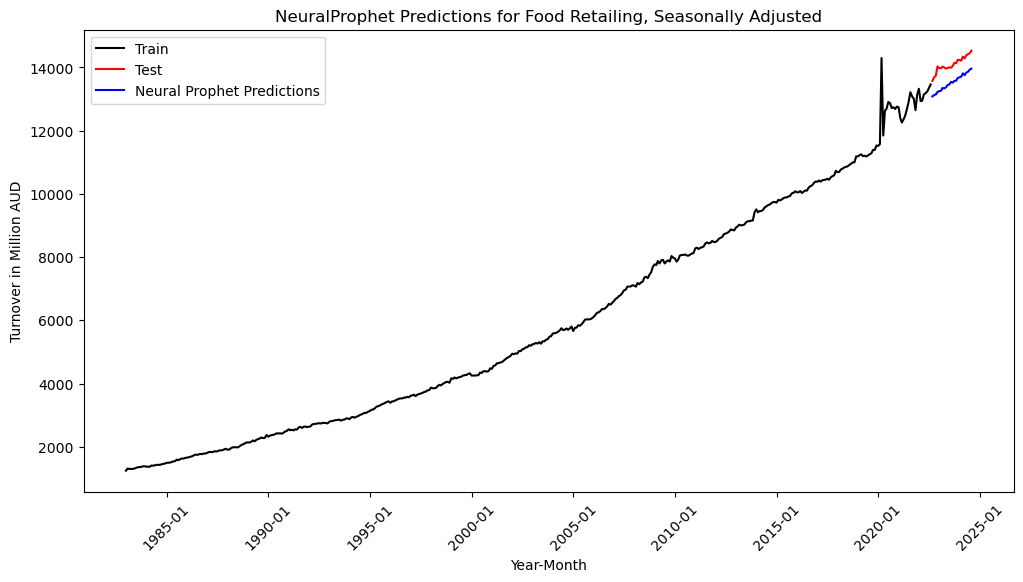

In [45]:
# Define the output
y = train['Food']
y_label_np = "Neural Prophet Predictions"


# Plot the Results
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train['Food'], label='Train', color='black')
plt.plot(test.index, test['Food'], label='Test', color='red')

# Plot the Neural Prophet predictions
plt.plot(y_pred_np_df.index, y_pred_np_df['yhat1'], color='blue', label=y_label_np)

# Labels and Title
plt.title('NeuralProphet Predictions for Food Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()
plt.show()

In [46]:
# Calculate RMSE for NeuralProphet
rmse_np = np.sqrt(mean_squared_error(test['Food'].values, y_pred_np_df['yhat1']))
print("NeuralProphet RMSE: ", rmse_np)

NeuralProphet RMSE:  584.1208847809156


In [47]:
# REVISIT
rmse_np = np.sqrt(mean_squared_error(test['Food'].values, y_pred_np_df['yhat1']))
rsqd_np = r2_score(test['Food'].values, y_pred_np_df['yhat1'])
print("NeuralProphet -> RMSE: ", rmse_np, "R-squared: ", rsqd_np)

NeuralProphet -> RMSE:  584.1208847809156 R-squared:  -5.218090444866653


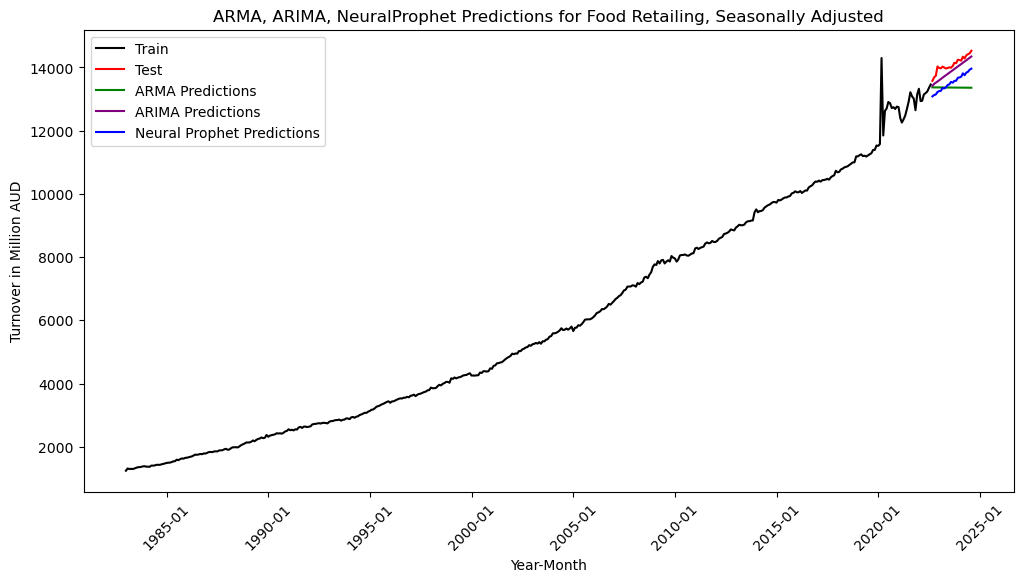

In [48]:
# Plot the Results
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train['Food'], label='Train', color='black')
plt.plot(test.index, test['Food'], label='Test', color='red')

# Plot the ARMA predictions
plt.plot(y_pred_arma_df[y_label_arma].index, y_pred_arma_df[y_label_arma], color='green', label=y_label_arma)

# Plot ARIMA Predictions
plt.plot(y_pred_arima_df.index, y_pred_arima_df[y_label_arima], color='purple', label=y_label_arima)

# Plot NeuralProphet predictions
plt.plot(y_pred_np_df.index, y_pred_np_df['yhat1'], color='blue', label=y_label_np)

# Labels and Title
plt.title('ARMA, ARIMA, NeuralProphet Predictions for Food Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()